# siamese networks for whale classification

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.rendered_html { font-size: 18px; }</style>"))

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import os, time, itertools
from skimage import io, transform
import skimage
import glob
from tqdm import tnrange, tqdm
from collections import Counter
from random import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import euclidean_distances
from IPython.display import clear_output

%matplotlib inline

# Load Data

In [7]:
# some prep steps
data_folder = "data/"

In [14]:
#load .npz-file from folder



loader = np.load(data_folder+"humpback_300x100_gray_no_new.npz")
features = loader["features"]
labels = loader["labels"]

n_rows = labels.shape[0]



split_ratio = 0.8
data_size = 500
expansion_factor = 8

#take the sample from the most common classes
ar = np.array(Counter(labels).most_common())
count = 0
label_list = []
for idx, tup in enumerate(ar):
    label_list.append(tup[0])
    count += tup[1]
    if count > data_size:
        break
label_list

label_in_list=[x in label_list for x in labels]
labels = labels[label_in_list]
features = features[label_in_list]

def standardize(X):
    X = X.astype(np.float32)
    X = (X - np.mean(X, axis=(1,2), keepdims=True)) / np.std(X, axis=(1,2), keepdims=True)
    return X

features = standardize(features)
features = np.expand_dims(features, axis=1)

all_combinations_without_labels = np.array(list(itertools.combinations(range(data_size),2)))
same_label_indices = labels[all_combinations_without_labels[:,0]] == labels[all_combinations_without_labels[:,1]]
all_combinations = np.append(all_combinations_without_labels, same_label_indices.reshape(-1,1), axis=1)

In [15]:
def train_test_split_old(split_ratio):
    """
    Get unique combinations from [0..data_size].
    Shuffle same_label_pairs and dif_label_pairs individually.
    Sample the first split_ratio*num pairs of each class for training and 
    sample the the rest (1-split_ratio)*num pairs of each class for validation
    
    """
    same_label_pairs = np.random.permutation(all_combinations[same_label_indices])
    dif_label_pairs = np.random.permutation(all_combinations[~same_label_indices])
    
    num_pairs = int(1/2*expansion_factor*data_size)
    num_train = int(split_ratio*num_pairs)
   
    train_matchings = np.append(same_label_pairs[:num_train], dif_label_pairs[:num_train], axis = 0)
    val_matchings = np.append(same_label_pairs[num_train:num_pairs], dif_label_pairs[num_train:num_pairs], axis = 0)
    
    np.random.shuffle(train_matchings), np.random.shuffle(val_matchings)
    
    return train_matchings.astype(int), val_matchings.astype(int)

In [16]:
def train_test_split(split_ratio):
    """
    First seperate all pictures into train_idx and val_idx. 
    Get unique combinations for each train_matchings and val_matchings.
    Shuffle same_label_pairs and dif_label_pairs individually.
    Sample the first split_ratio*num pairs of each class for training and 
    sample the the rest (1-split_ratio)*num pairs of each class for validation
    
    """
    perm = np.random.permutation(range(data_size))
    train_idx = perm[:int(split_ratio*data_size)]
    val_idx = perm[int(split_ratio*data_size):]
    
    def sample(idx, num_train):
        combinations = np.array(list(itertools.combinations(idx,2)))

        same_label_indices = labels[combinations[:,0]] == labels[combinations[:,1]]
        combinations = np.append(combinations, same_label_indices.reshape(-1,1), axis=1)

        same_label_pairs = np.random.permutation(combinations[same_label_indices])
        dif_label_pairs = np.random.permutation(combinations[~same_label_indices])
        
        matchings = np.append(same_label_pairs[:num_train], dif_label_pairs[:num_train], axis = 0)
        return matchings
    
    num_pairs = int(1/2*expansion_factor*data_size)
    train_matchings = sample(train_idx, num_train=int(split_ratio*num_pairs))
    val_matchings = sample(val_idx, num_train=int((1-split_ratio)*num_pairs))
    
    print("num train:", train_matchings.shape, "num val:", val_matchings.shape)
    
    np.random.shuffle(train_matchings), np.random.shuffle(val_matchings)
    return train_matchings.astype(int), val_matchings.astype(int)

### Train Test Split

In [17]:
train_matchings, val_matchings = train_test_split(split_ratio)

num train: (3200, 3) num val: (798, 3)


## Helper functions for calculation of accuracy

In [18]:
def get_unique_N(iterable, N):
    """Yields (in order) the first N unique elements of iterable. 
    Might yield less if data too short."""
    seen = set()
    for e in iterable:
        if e in seen:
            continue
        seen.add(e)
        yield e
        if len(seen) == N:
            return

In [19]:
def get_k_nearest(distance_matrix):
    dm = distance_matrix.copy()
    for i in range(dm.shape[0]):    
        dm[i,i] += 100000 
    nearest = np.empty(shape=(dm.shape[0], dm.shape[0]))
    for i in range(dm.shape[0]):
        nearest[:,i] = np.argmin(dm, axis=0)
        dm[nearest[:,i].astype(int)] += 100000
        nearest[:,i] = labels[nearest[:,i].astype(int)]
    top5_nearest = np.empty((distance_matrix.shape[0], 5))
    for idx, line in enumerate(nearest):
        #import pdb; pdb.set_trace()
        top5_nearest[idx,:] = np.fromiter(get_unique_N(line, 5), int)
    return top5_nearest.astype(int)

In [20]:
def batch_data(num_data, batch_size):
    """ Yield batches with indices until epoch is over.
    
    Parameters
    ----------
    num_data: int
        The number of samples in the dataset.
    batch_size: int
        The batch size used using training.

    Returns
    -------
    batch_ixs: np.array of ints with shape [batch_size,]
        Yields arrays of indices of size of the batch size until the epoch is over.
    """
    
    data_ixs = np.random.permutation(np.arange(num_data))
    ix = 0
    while ix + batch_size < num_data:
        batch_ixs = data_ixs[ix:ix+batch_size]
        ix += batch_size
        yield batch_ixs

# Check initializer of variables

In [21]:
class SiamN:
    
    def __init__(self, name, learning_rate=0.001):
        
        self.name = name
        self.dropout = tf.placeholder_with_default(0.0, shape=(), name="dropout")
        self.learning_rate = learning_rate
        self.weights =[]
        self.biases =[]
    
    def build(self, length=300, height=100, channels=1, margin=0.5):

        self.X_1 = tf.placeholder(shape=[None, channels, height, length], dtype=tf.float32, name="data_1") #[NxD]
        self.X_2 = tf.placeholder(shape=[None, channels, height, length], dtype=tf.float32, name="data_2")
        self.Y = tf.placeholder(shape=[None,], dtype=tf.float32, name="labels") #[Nx1]
        with tf.variable_scope(self.name, reuse=tf.AUTO_REUSE):
        
            first_hidden = self.X_1
            first_conv1 = tf.layers.conv2d(inputs=first_hidden, filters=16, kernel_size=2, strides=1,
                padding='same', activation = tf.nn.relu)
            first_max_pool_1 = tf.layers.max_pooling2d(inputs=first_conv1, pool_size=2, strides=2, padding='same')
            first_conv2 = tf.layers.conv2d(inputs=first_max_pool_1, filters=32, kernel_size=2, strides=1,
                padding='same', activation = tf.nn.relu)
            first_max_pool_2 = tf.layers.max_pooling2d(inputs=first_conv2, pool_size=5, strides=2, padding='same')
            first_hidden = tf.contrib.layers.flatten(first_max_pool_2)
            first_hidden = tf.nn.dropout(first_hidden, 1-self.dropout)
            first_hidden = tf.contrib.layers.fully_connected(first_hidden, 20, activation_fn = None)

            self.outputs = first_hidden
            
            second_hidden = self.X_2
            second_conv1 = tf.layers.conv2d(inputs=second_hidden, filters=16, kernel_size=2, strides=1,
                padding='same', activation = tf.nn.relu)
            second_max_pool_1 = tf.layers.max_pooling2d(inputs=second_conv1, pool_size=2, strides=2, padding='same')
            second_conv2 = tf.layers.conv2d(inputs=second_max_pool_1, filters=32, kernel_size=2, strides=1,
                padding='same', activation = tf.nn.relu)
            second_max_pool_2 = tf.layers.max_pooling2d(inputs=second_conv2, pool_size=5, strides=2, padding='same')
            second_hidden = tf.contrib.layers.flatten(second_max_pool_2)
            second_hidden = tf.nn.dropout(second_hidden, 1-self.dropout)
            second_hidden = tf.contrib.layers.fully_connected(second_hidden, 20, activation_fn = None)
            
            
            self.distance = tf.norm(first_hidden - second_hidden)
            self.similarity = (1-self.Y) * tf.square(self.distance)                                           # keep the similar label (1) close to each other
            self.dissimilarity = self.Y * tf.square(tf.maximum((margin - self.distance), 0))        # give penalty to dissimilar label if the distance is bigger than margin
            self.loss = tf.reduce_mean((self.dissimilarity + self.similarity) / 2)
            self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.loss)
            
        
    def train(self, features, train_matchings, val_matchings, epochs=20, dropout=0.0, batch_size=512):

        train_losses = []
        val_losses = []
        
        config = tf.ConfigProto()
        #config.gpu_options.allow_growth=True
        self.session = tf.Session(config=config)
        session = self.session
        
        session.run(tf.global_variables_initializer())

        tr_loss = session.run(self.loss, feed_dict={self.X_1: features[train_matchings[:,0]], self.X_2: features[train_matchings[:,1]], self.Y: train_matchings[:,2]})
        val_loss = session.run(self.loss, feed_dict={self.X_1: features[val_matchings[:,0]], self.X_2: features[val_matchings[:,1]], self.Y: val_matchings[:,2]})
        
        train_losses.append(tr_loss)            
        val_losses.append(val_loss)
        print(f"Epoch 0/{epochs} train_loss: {train_losses[-1]} val_loss: {val_losses[-1]}")


        for epoch in range(epochs):
            if (epoch+1) % 5 == 0:
                print(f"Epoch {epoch+1}/{epochs} train_loss: {train_losses[-1]} val_loss: {val_losses[-1]}")  
            for batch_ixs in batch_data(train_matchings.shape[0], batch_size):
                    _ = session.run( self.optimizer, feed_dict={self.X_1: features[train_matchings[batch_ixs,0]], self.X_2: features[train_matchings[batch_ixs,1]], self.Y: train_matchings[batch_ixs,2]})  
            tr_loss = session.run(self.loss, feed_dict={self.X_1: features[train_matchings[:,0]], self.X_2: features[train_matchings[:,1]], self.Y: train_matchings[:,2]})
            val_loss = session.run(self.loss, feed_dict={self.X_1: features[val_matchings[:,0]], self.X_2: features[val_matchings[:,1]], self.Y: val_matchings[:,2]})
            train_losses.append(round(tr_loss/train_matchings.shape[0], 7))
            val_losses.append(round(val_loss/val_matchings.shape[0], 7))

        
        
        self.hist={'train_loss': np.array(train_losses),
           'val_loss': np.array(val_losses), "epochs_trained": epoch}
        

In [22]:
model1.session.close()

NameError: name 'model1' is not defined

In [23]:
#You can change layer types and the number of neurons by changing the following variables.
t = time.time()
epochs = 15
batch_size = 256


model1 = SiamN("first_model", learning_rate = 0.001)
model1.build(margin=1)

model1.train(features, train_matchings, val_matchings, epochs, batch_size=batch_size)
print("Training finished in", time.time()-t,"s.")

Epoch 0/15 train_loss: 10852.4775390625 val_loss: 2397.732177734375
Epoch 5/15 train_loss: 0.0635335 val_loss: 0.0842545
Epoch 10/15 train_loss: 0.0257305 val_loss: 0.0510196
Epoch 15/15 train_loss: 0.0153327 val_loss: 0.0395537


In [24]:
outputs = model1.session.run(model1.outputs, feed_dict = {model1.X_1:features})
distance_matrix = euclidean_distances(outputs)

In [25]:
labels.shape

(522,)

In [26]:
#import pdb; pdb.pm()
top5_nearest = get_k_nearest(distance_matrix)

In [27]:
a = np.array([0,0,0,1,1])
np.argmin(a)

0

In [28]:
true_labels = np.repeat(np.array([labels]), 5, axis=0).T

In [29]:
prediction_matrix = top5_nearest == true_labels
weights_standard = np.array([1, 0.8, 0.6, 0.4, 0.2])
weights_first = np.array([1,0,0,0,0])
weights_half = np.array([1,0.5,0.33,0.25,0.20])
scores_per_image = prediction_matrix@weights_standard
score = np.sum(scores_per_image)/scores_per_image.shape[0]

In [30]:
score

0.3632183908045977

In [31]:
np.fromiter(get_unique_N(nearest[0], 5), int)

NameError: name 'nearest' is not defined

In [ ]:
top_5_nearest = np.empty(distance_matrix.shape[0])
for line in nearest:
    for entry in line:
                

In [ ]:
a = np.array([[2,5,1,6,3], [1,2,3,4,5]])
np.argmin(a, axis=1)

same whales? False
Index:  866
0.19923122


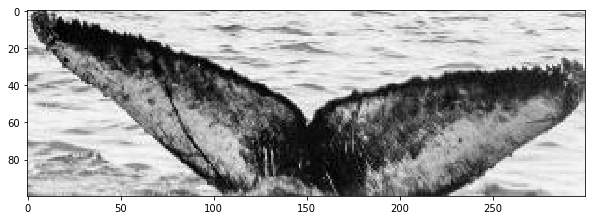

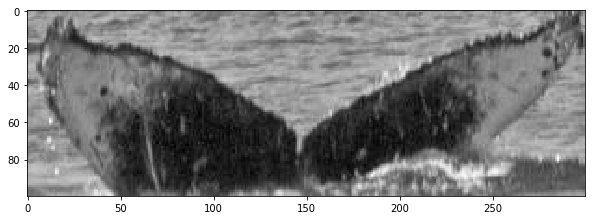

In [43]:
idx = np.random.randint(3200)
pic_a = features[train_matchings[idx,0]]
pic_b = features[train_matchings[idx,1]]
print(f"same whales? {bool(train_matchings[idx,2])}")    
print("Index: ", idx)
loss = model1.session.run(model1.distance, feed_dict={model1.X_1: np.array([pic_a]), model1.X_2: np.array([pic_b]), model1.Y: np.array([train_matchings[idx,2]])})
print(loss)
plt.figure(figsize=(10,5))
plt.imshow(pic_a[0], cmap="gray")
plt.figure(figsize=(10,5))
plt.imshow(pic_b[0], cmap="gray")

In [34]:
losses = []
for idx in tqdm(range(3200)):
    loss = model1.session.run(model1.loss, feed_dict={model1.X_1: np.array([train_data[idx][0]]), model1.X_2: np.array([train_data[idx][1]]), model1.Y: np.array([train_labels[idx]])})
    losses.append(loss)

  0%|          | 0/3200 [00:00<?, ?it/s]


NameError: name 'train_data' is not defined

In [ ]:
outlier_indices = [not (0.03<x<0.04) for x in losses]
sum(outlier_indices)

In [ ]:
train_data[0,0,0].shape

In [ ]:
for i in range(len(outlier_indices)):
    if outlier_indices[i]:
        print(f"Dissimilarity: {losses[i]}")
        print(f"Correct Label: {train_labels[i]}")
        print("Picture 1: ")
        plt.figure(figsize=(10,5))
        plt.imshow(train_data[i,0,0], cmap="gray")
        plt.show()
        print("Picture 2: ")
        plt.figure(figsize=(10,5))
        plt.imshow(train_data[i,1,0], cmap="gray")
        plt.show()

In [ ]:
pic_a= train_data[1441][0]
plt.figure(figsize=(10,5))
plt.imshow(pic_a[0], cmap="gray")
plt.show()
print(train_labels[1441])

In [ ]:
model1.show_example()

In [ ]:

print("model 1")
plt.figure(figsize=(10,5))
plt.plot(model1.hist['train_loss'][5::], label="Training")
plt.plot(model1.hist['val_loss'][5::], label="Validation")

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.legend()
plt.show()
"""
print("model 2")
plt.figure(figsize=(10,5))
plt.plot(model2.hist['train_loss'][5::], label="Training")
plt.plot(model2.hist['val_loss'][5::], label="Validation")

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.legend()
plt.show()
"""

In [ ]:
print(model1.hist["train_loss"])

#### Now plot the training and validation accuracies over the epochs.

In [ ]:
print("model 1")
plt.figure(figsize=(10,5))

plt.plot(model1.hist['train_accuracy'])
plt.plot(model1.hist['val_accuracy'])

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)

plt.show()
"""
print("model 2")
plt.figure(figsize=(10,5))

plt.plot(model2.hist['train_accuracy'])
plt.plot(model2.hist['val_accuracy'])

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)

plt.show()
"""

In [ ]:
train_acc_1 = model1.hist['train_accuracy'][-1]
val_acc_1 = model1.hist['val_accuracy'][-1]
"""
train_acc_2 = model2.hist['train_accuracy'][-1]
val_acc_2 = model2.hist['val_accuracy'][-1]
"""
print(f"Training accuracy model 1: {train_acc_1:.3f}")
print(f"Validation accuracy model 1: {val_acc_1:.3f}")
print()
"""
print(f"Training accuracy model 2: {train_acc_2:.3f}")
print(f"Validation accuracy model 2: {val_acc_2:.3f}")
print()
"""

### Plot the losses and accuracies of the models in one plot to compare them.

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(model1.hist['train_loss'][5::], label="Training model 1",
        color="darkgreen")
plt.plot(model1.hist['val_loss'][5::], label="Validation model 1",
        color="darkgreen", linestyle="--")
"""
plt.plot(model2.hist['train_loss'][5::], label="Training model 2",
        color="royalblue")
plt.plot(model2.hist['val_loss'][5::], label="Validation model 2",
        color="royalblue", linestyle="--")
"""
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.legend()
plt.show()

## Comparing the models
Now, compare the final training and validation losses achieved by the different models.

In [ ]:
plt.figure(figsize=(10,5))

plt.plot(model1.hist['train_accuracy'], label="Training model 1",
        color="darkgreen")
plt.plot(model1.hist['val_accuracy'], label="Validation model 1",
        color="darkgreen", linestyle="--")

plt.plot(model2.hist['train_accuracy'], label="Training model 2",
        color="royalblue")
plt.plot(model2.hist['val_accuracy'], label="Validation model 2",
        color="royalblue", linestyle="--")

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.legend()
plt.show()

In [ ]:
test_preds = NN_dropout_regularization.logits.eval({NN_dropout_regularization.X: test_data},
                                        session=NN_dropout_regularization.session).argmax(1)

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices({"feature": train_data, "label": train_labels})
val_data = tf.data.Dataset.from_tensor_slices({"feature": val_data, "label": val_labels})
train_data

In [ ]:
train_data.output_types

In [ ]:
#build batches
batch_size = 500
train_data.shuffle(30000)
batches = dataset.batch(batch_size)

In [ ]:


sess = tf.Session()
iterator = batches.make_one_shot_iterator()
next_element = iterator.get_next()
no_of_batches = int(np.ceil(labels.shape[0] / batch_size))
counter = 1
for i in tqdm(range(no_of_batches)):
    value = sess.run(next_element)
    print(value["feature"].shape)
    print(counter)
    counter+=1

sess.close()